# Keyword extraction

In [1]:
import knowledge_graph

kg = knowledge_graph.KnowledgeGraph()
kg.extract_knowledge_graph(printout=False)
kg.extract_synonyms(printout=False)

In [2]:
categories = sorted(list(kg.cyber_security.keys()))
categories

['assets',
 'business',
 'emerging_technology',
 'general_terms',
 'geopolitics',
 'policy',
 'security_software_hardware',
 'threat_actors',
 'threats']

In [3]:
terms_per_category = dict()
for category in categories:
    terms_per_category[category] = kg.get_terms_per_category(category)
terms_per_category

{'assets': ['assets',
  'data',
  'services',
  'physical assets equipment',
  'devices',
  'hardware',
  'software',
  'information',
  'people',
  'reputation',
  'intellectual property',
  'ip',
  'brand'],
 'business': ['business',
  'public private partnerships',
  'ppp',
  'cybersecurity companies',
  'black market',
  'valuation',
  'stock options',
  'stock market',
  'insurance',
  'fine',
  'bankruptcy',
  'alliance',
  'ipo',
  'partnership',
  'funding',
  'acquisition',
  'merger',
  'industry',
  'critical infrastructure',
  'operator of essential service',
  'sme',
  'startup',
  'award',
  'technology companies',
  'google',
  'amazon',
  'facebook',
  'apple',
  'twitter',
  'linkedin'],
 'emerging_technology': ['emerging technology',
  'biometrics',
  'cloud technology',
  'deep learning',
  'machine learning',
  'virtual reality',
  'vr',
  'augmented reality',
  'ar',
  'nano technology',
  'robotics',
  'software-defined networking',
  'sdn',
  '5g',
  'iot',
  'au

In [4]:
from enisa_elastic.elastic import elastic_to_df

df = elastic_to_df('websites')
#df = elastic_to_df('rssfeeds')

Total number of entries: 33472


[========================================================================] 100%


Turning the _source items into columns.


In [113]:
print(len(df))
df.columns

33472


Index(['_id', '_score', 'content', 'resource_label', 'link', 'resource_link',
       'title', 'published'],
      dtype='object')

In [114]:
#print(len(df[df['description'] == '']))
print("Number of documents with empty content:", len(df[df['content'] == '']))

Number of documents with empty content: 105


In [115]:
def get_any_label(text):
    contains_terms = False
    for c in categories:
        for term in terms_per_category[c]:
            if len(term) >= 3:
                contains_terms = contains_terms | (term in text)
    return 1 if contains_terms else 0

has_any_label = df['content'].apply(get_any_label)
print("Number of documents containing no term from the knowledge graph:", len(has_any_label) - sum(has_any_label))

Number of documents containing no term from the knowledge graph: 1127


In [116]:
def get_label(text):
    contains_terms = False
    for term in terms_per_category[category]:
        if len(term) >= 3:
            contains_terms = contains_terms | (term in text)
    return 1 if contains_terms else 0

In [117]:
from sklearn.feature_extraction import stop_words
import re

REGEX_STOP_WORDS = r"\b("
REGEX_STOP_WORDS += '|'.join(stop_words.ENGLISH_STOP_WORDS)
REGEX_STOP_WORDS += r")\b"

def preproc(s):
    return re.compile(REGEX_STOP_WORDS).sub(" ", s.lower())

In [118]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(ngram_range=(1, 2), preprocessor=preproc, stop_words='english')
cv1 = CountVectorizer(ngram_range=(1, 1), preprocessor=preproc, stop_words='english')
cv2 = CountVectorizer(ngram_range=(2, 2), preprocessor=preproc, stop_words='english')

In [119]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv = TfidfVectorizer(ngram_range=(1, 2), preprocessor=preproc, stop_words='english', min_df=0.001, max_df=0.1)
tv1 = TfidfVectorizer(ngram_range=(1, 1), preprocessor=preproc, stop_words='english', min_df=0.001, max_df=0.1)
tv2 = TfidfVectorizer(ngram_range=(2, 2), preprocessor=preproc, stop_words='english', min_df=0.001, max_df=0.1)

In [120]:
from pdf_documents import *

#model_path = "../glove.6B.50d.txt"
model_path = "../glove.6B.300d.txt"
with open(model_path, "r") as lines:
    w2v = {line.split()[0]: np.array(line.split()[1:], dtype=float) for line in lines}

mean_embed = Pipeline([
        ("preproc", Preprocess(preproc)),
        ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v))])
tfidf_embed = Pipeline([
        ("preproc", Preprocess(preproc)),
        ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v))])

In [121]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

#glove = Pipeline([
#        ("preproc", Preprocess(preproc)),
#        ("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)),
#        ("extra trees", ExtraTreesClassifier(n_estimators=200))])

et = ExtraTreesClassifier(n_estimators=10)
rf = RandomForestClassifier(n_estimators=10)
nb = MultinomialNB()
svm = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)
lr = LogisticRegression(max_iter=1000)

def train(model):
    y = df['content'].apply(get_label)
    print("Number of positive (all) labels: {} ({})".format(y.sum(), y.shape[0]))
    # Ensure both classes are present.
    if min(y.sum(), y.shape[0] - y.sum()) < min_num_per_class:
        return

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
    print("Number of positive labels in the train (test) set: {} ({})".format(np.sum(y_train), np.sum(y_test)))
    
    # Train a model.
    clf = model.fit(X_train, y_train)
    
    # Print the performance metrics on the training set.
    y_pred = clf.predict(X_train)
#    y_prob = clf.predict_proba(X_train)[:, 1]
    acc_train = np.mean(y_pred == y_train)
#    roc_auc_train = roc_auc_score(y_train, y_prob)
    f1_train = f1_score(y_train, y_pred)
    print("Accuracy on the train set: {:.3f}".format(acc_train))
#    print("Area under the ROC curve: {:.3f}".format(roc_auc_train))
    print("F1 score: {:.3f}".format(f1_train))
    print(confusion_matrix(y_train, y_pred))
    
    # Print the performance metrics on the test set.
    y_pred = clf.predict(X_test)
#    y_prob = clf.predict_proba(X_test)[:, 1]
    acc_test = np.mean(y_pred == y_test)
#    roc_auc_test = roc_auc_score(y_test, y_prob)
    f1_test = f1_score(y_test, y_pred)
    print("Accuracy on the test set: {:.3f}".format(acc_test))
#    print("Area under the ROC curve: {:.3f}".format(roc_auc_test))
    print("F1 score: {:.3f}".format(f1_test))
    print(confusion_matrix(y_test, y_pred))
    
    return {
        "acc_train": acc_train, "acc_test": acc_test,
#        "roc_auc_train": roc_auc_train, "roc_auc_test": roc_auc_test,
        "f1_train": f1_train, "f1_test": f1_test}

In [122]:
X0 = df['content']
X = cv1.fit_transform(X0)
print("Shape of the X matrix:", X.shape)

Shape of the X matrix: (33472, 118078)


In [123]:
min_num_per_class = 100

performance_nb_cv1 = dict()
for category in categories:
    print('-'*80)
    print(category)
    print('-'*80)
    performance_nb_cv1[category] = train(nb)
    print()

--------------------------------------------------------------------------------
assets
--------------------------------------------------------------------------------
Number of positive (all) labels: 28065 (33472)
Number of positive labels in the train (test) set: 18803 (9262)
Accuracy on the train set: 0.851
F1 score: 0.909
[[ 2504  1119]
 [ 2213 16590]]
Accuracy on the test set: 0.805
F1 score: 0.880
[[ 966  818]
 [1336 7926]]

--------------------------------------------------------------------------------
business
--------------------------------------------------------------------------------
Number of positive (all) labels: 18121 (33472)
Number of positive labels in the train (test) set: 12141 (5980)
Accuracy on the train set: 0.790
F1 score: 0.802
[[8146 2139]
 [2575 9566]]
Accuracy on the test set: 0.750
F1 score: 0.766
[[3780 1286]
 [1470 4510]]

--------------------------------------------------------------------------------
emerging_technology
-----------------------------

In [124]:
def remove_terms(text):
    for term in terms_per_category[category]:
        text = text.replace(term, '')
    return text

In [125]:
X0 = df['content'].apply(remove_terms)
X = cv1.fit_transform(X0)
print("Shape of the X matrix:", X.shape)

Shape of the X matrix: (33472, 117983)


In [126]:
min_num_per_class = 100

performance_nb_cv1_removed = dict()
for category in categories:
    print('-'*80)
    print(category)
    print('-'*80)
    performance_nb_cv1_removed[category] = train(nb)
    print()

--------------------------------------------------------------------------------
assets
--------------------------------------------------------------------------------
Number of positive (all) labels: 28065 (33472)
Number of positive labels in the train (test) set: 18803 (9262)
Accuracy on the train set: 0.852
F1 score: 0.909
[[ 2488  1135]
 [ 2180 16623]]
Accuracy on the test set: 0.806
F1 score: 0.881
[[ 962  822]
 [1323 7939]]

--------------------------------------------------------------------------------
business
--------------------------------------------------------------------------------
Number of positive (all) labels: 18121 (33472)
Number of positive labels in the train (test) set: 12141 (5980)
Accuracy on the train set: 0.791
F1 score: 0.803
[[8157 2128]
 [2569 9572]]
Accuracy on the test set: 0.752
F1 score: 0.767
[[3792 1274]
 [1464 4516]]

--------------------------------------------------------------------------------
emerging_technology
-----------------------------

In [127]:
X0 = df['content'].apply(remove_terms)
X = cv.fit_transform(X0)
print("Shape of the X matrix:", X.shape)

Shape of the X matrix: (33472, 4450004)


In [128]:
min_num_per_class = 100

performance_nb_cv_removed = dict()
for category in categories:
    print('-'*80)
    print(category)
    print('-'*80)
    performance_nb_cv_removed[category] = train(nb)
    print()

--------------------------------------------------------------------------------
assets
--------------------------------------------------------------------------------
Number of positive (all) labels: 28065 (33472)
Number of positive labels in the train (test) set: 18803 (9262)
Accuracy on the train set: 0.880
F1 score: 0.933
[[  936  2687]
 [   10 18793]]
Accuracy on the test set: 0.849
F1 score: 0.917
[[ 128 1656]
 [  15 9247]]

--------------------------------------------------------------------------------
business
--------------------------------------------------------------------------------
Number of positive (all) labels: 18121 (33472)
Number of positive labels in the train (test) set: 12141 (5980)
Accuracy on the train set: 0.926
F1 score: 0.933
[[ 9202  1083]
 [  573 11568]]
Accuracy on the test set: 0.756
F1 score: 0.783
[[3509 1557]
 [1135 4845]]

--------------------------------------------------------------------------------
emerging_technology
-------------------------

In [129]:
X0 = df['content'].apply(remove_terms)
X = tv1.fit_transform(X0)
print("Shape of the X matrix:", X.shape)

Shape of the X matrix: (33472, 12954)


In [130]:
min_num_per_class = 100

performance_nb_tv1_removed = dict()
for category in categories:
    print('-'*80)
    print(category)
    print('-'*80)
    performance_nb_tv1_removed[category] = train(nb)
    print()

--------------------------------------------------------------------------------
assets
--------------------------------------------------------------------------------
Number of positive (all) labels: 28065 (33472)
Number of positive labels in the train (test) set: 18803 (9262)
Accuracy on the train set: 0.859
F1 score: 0.921
[[  815  2808]
 [  365 18438]]
Accuracy on the test set: 0.851
F1 score: 0.917
[[ 334 1450]
 [ 198 9064]]

--------------------------------------------------------------------------------
business
--------------------------------------------------------------------------------
Number of positive (all) labels: 18121 (33472)
Number of positive labels in the train (test) set: 12141 (5980)
Accuracy on the train set: 0.766
F1 score: 0.779
[[7971 2314]
 [2928 9213]]
Accuracy on the test set: 0.743
F1 score: 0.757
[[3786 1280]
 [1555 4425]]

--------------------------------------------------------------------------------
emerging_technology
-----------------------------

In [131]:
X0 = df['content'].apply(remove_terms)
X = tv1.fit_transform(X0)
print("Shape of the X matrix:", X.shape)

Shape of the X matrix: (33472, 12954)


In [132]:
min_num_per_class = 100

performance_svm_tv1_removed = dict()
for category in categories:
    print('-'*80)
    print(category)
    print('-'*80)
    performance_svm_tv1_removed[category] = train(svm)
    print()

--------------------------------------------------------------------------------
assets
--------------------------------------------------------------------------------
Number of positive (all) labels: 28065 (33472)
Number of positive labels in the train (test) set: 18803 (9262)
Accuracy on the train set: 0.848
F1 score: 0.917
[[  249  3374]
 [   43 18760]]
Accuracy on the test set: 0.846
F1 score: 0.916
[[ 102 1682]
 [  17 9245]]

--------------------------------------------------------------------------------
business
--------------------------------------------------------------------------------
Number of positive (all) labels: 18121 (33472)
Number of positive labels in the train (test) set: 12141 (5980)
Accuracy on the train set: 0.796
F1 score: 0.801
[[8663 1622]
 [2947 9194]]
Accuracy on the test set: 0.781
F1 score: 0.786
[[4179  887]
 [1531 4449]]

--------------------------------------------------------------------------------
emerging_technology
-----------------------------

/Users/ds186095/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------------------------------------------------------
Number of positive (all) labels: 17095 (33472)
Number of positive labels in the train (test) set: 11454 (5641)
Accuracy on the train set: 0.736
F1 score: 0.714
[[9101 1871]
 [4059 7395]]
Accuracy on the test set: 0.720
F1 score: 0.695
[[4421  984]
 [2114 3527]]

--------------------------------------------------------------------------------
security_software_hardware
--------------------------------------------------------------------------------
Number of positive (all) labels: 8713 (33472)
Number of positive labels in the train (test) set: 5838 (2875)
Accuracy on the train set: 0.748
F1 score: 0.063
[[16587     1]
 [ 5647   191]]
Accuracy on the test set: 0.749
F1 score: 0.069
[[8171    0]
 [2773  102]]

--------------------------------------------------------------------------------
threat_actors
--------------------------------------------------------------------------------
Number of positive (all) l

In [133]:
X0 = df['content'].apply(remove_terms)
X = mean_embed.fit_transform(X0)
print("Shape of the X matrix:", X.shape)

Shape of the X matrix: (33472, 300)


In [134]:
min_num_per_class = 100

performance_rf_meanembed_removed = dict()
for category in categories:
    print('-'*80)
    print(category)
    print('-'*80)
    performance_rf_meanembed_removed[category] = train(rf)
    print()

--------------------------------------------------------------------------------
assets
--------------------------------------------------------------------------------
Number of positive (all) labels: 28065 (33472)
Number of positive labels in the train (test) set: 18803 (9262)
Accuracy on the train set: 0.994
F1 score: 0.996
[[ 3529    94]
 [   40 18763]]
Accuracy on the test set: 0.854
F1 score: 0.915
[[ 734 1050]
 [ 561 8701]]

--------------------------------------------------------------------------------
business
--------------------------------------------------------------------------------
Number of positive (all) labels: 18121 (33472)
Number of positive labels in the train (test) set: 12141 (5980)
Accuracy on the train set: 0.989
F1 score: 0.990
[[10235    50]
 [  198 11943]]
Accuracy on the test set: 0.707
F1 score: 0.711
[[3828 1238]
 [1999 3981]]

--------------------------------------------------------------------------------
emerging_technology
-------------------------

/Users/ds186095/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Number of positive (all) labels: 17095 (33472)
Number of positive labels in the train (test) set: 11454 (5641)
Accuracy on the train set: 0.986
F1 score: 0.986
[[10907    65]
 [  242 11212]]
Accuracy on the test set: 0.647
F1 score: 0.629
[[3850 1555]
 [2343 3298]]

--------------------------------------------------------------------------------
security_software_hardware
--------------------------------------------------------------------------------
Number of positive (all) labels: 8713 (33472)
Number of positive labels in the train (test) set: 5838 (2875)
Accuracy on the train set: 0.979
F1 score: 0.958
[[16580     8]
 [  464  5374]]
Accuracy on the test set: 0.739
F1 score: 0.207
[[7788  383]
 [2498  377]]

--------------------------------------------------------------------------------
threat_actors
--------------------------------------------------------------------------------
Number of positive (all) labels: 2889 (33472)
Number of positive labels in the train (test) set: 1936 (

In [135]:
min_num_per_class = 100

performance_lr_meanembed_removed = dict()
for category in categories:
    print('-'*80)
    print(category)
    print('-'*80)
    performance_lr_meanembed_removed[category] = train(lr)
    print()

--------------------------------------------------------------------------------
assets
--------------------------------------------------------------------------------
Number of positive (all) labels: 28065 (33472)
Number of positive labels in the train (test) set: 18803 (9262)
Accuracy on the train set: 0.852
F1 score: 0.919
[[  375  3248]
 [   73 18730]]
Accuracy on the test set: 0.854
F1 score: 0.919
[[ 207 1577]
 [  41 9221]]

--------------------------------------------------------------------------------
business
--------------------------------------------------------------------------------
Number of positive (all) labels: 18121 (33472)
Number of positive labels in the train (test) set: 12141 (5980)
Accuracy on the train set: 0.704
F1 score: 0.735
[[6605 3680]
 [2956 9185]]
Accuracy on the test set: 0.700
F1 score: 0.730
[[3241 1825]
 [1490 4490]]

--------------------------------------------------------------------------------
emerging_technology
-----------------------------

/Users/ds186095/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy on the train set: 0.979
F1 score: 0.000
[[21944     0]
 [  482     0]]
Accuracy on the test set: 0.979
F1 score: 0.000
[[10809     0]
 [  237     0]]

--------------------------------------------------------------------------------
policy
--------------------------------------------------------------------------------
Number of positive (all) labels: 17095 (33472)
Number of positive labels in the train (test) set: 11454 (5641)
Accuracy on the train set: 0.645
F1 score: 0.662
[[6677 4295]
 [3665 7789]]
Accuracy on the test set: 0.647
F1 score: 0.666
[[3260 2145]
 [1756 3885]]

--------------------------------------------------------------------------------
security_software_hardware
--------------------------------------------------------------------------------
Number of positive (all) labels: 8713 (33472)
Number of positive labels in the train (test) set: 5838 (2875)
Accuracy on the train set: 0.739
F1 score: 0.001
[[16573    15]
 [ 5834     4]]
Accuracy on the test set: 0.74

In [136]:
%matplotlib inline
import matplotlib.pyplot as plt

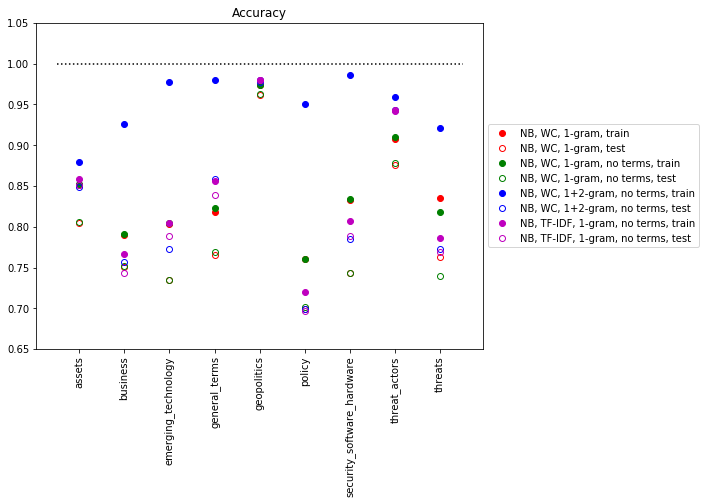

In [137]:
acc_train_nb_cv1 = [performance_nb_cv1[x]["acc_train"] if performance_nb_cv1[x] else 0 for x in categories]
acc_test_nb_cv1 = [performance_nb_cv1[x]["acc_test"] if performance_nb_cv1[x] else 0 for x in categories]
acc_train_nb_cv1_removed = [performance_nb_cv1_removed[x]["acc_train"] if performance_nb_cv1_removed[x] else 0 for x in categories]
acc_test_nb_cv1_removed = [performance_nb_cv1_removed[x]["acc_test"] if performance_nb_cv1_removed[x] else 0 for x in categories]
acc_train_nb_cv_removed = [performance_nb_cv_removed[x]["acc_train"] if performance_nb_cv_removed[x] else 0 for x in categories]
acc_test_nb_cv_removed = [performance_nb_cv_removed[x]["acc_test"] if performance_nb_cv_removed[x] else 0 for x in categories]
acc_train_nb_tv1_removed = [performance_nb_tv1_removed[x]["acc_train"] if performance_nb_tv1_removed[x] else 0 for x in categories]
acc_test_nb_tv1_removed = [performance_nb_tv1_removed[x]["acc_test"] if performance_nb_tv1_removed[x] else 0 for x in categories]

plt.figure(figsize=(8,6))
plt.plot(categories, acc_train_nb_cv1, "ro", fillstyle="full", label="NB, WC, 1-gram, train")
plt.plot(categories, acc_test_nb_cv1, "ro", fillstyle="none", label="NB, WC, 1-gram, test")
plt.plot(categories, acc_train_nb_cv1_removed, "go", fillstyle="full", label="NB, WC, 1-gram, no terms, train")
plt.plot(categories, acc_test_nb_cv1_removed, "go", fillstyle="none", label="NB, WC, 1-gram, no terms, test")
plt.plot(categories, acc_train_nb_cv_removed, "bo", fillstyle="full", label="NB, WC, 1+2-gram, no terms, train")
plt.plot(categories, acc_test_nb_cv_removed, "bo", fillstyle="none", label="NB, WC, 1+2-gram, no terms, test")
plt.plot(categories, acc_train_nb_tv1_removed, "mo", fillstyle="full", label="NB, TF-IDF, 1-gram, no terms, train")
plt.plot(categories, acc_test_nb_tv1_removed, "mo", fillstyle="none", label="NB, TF-IDF, 1-gram, no terms, test")
plt.xticks(rotation='vertical')
plt.ylim([0.65, 1.05])
plt.plot([-.5, len(categories)-.5], [1, 1], 'k:')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Accuracy");

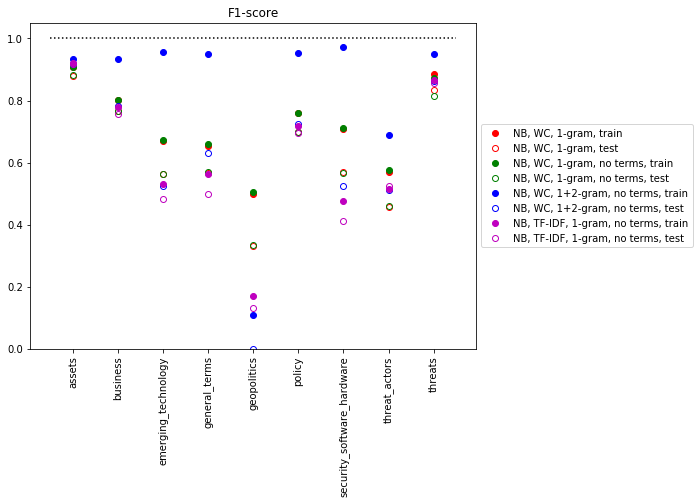

In [138]:
f1_train_nb_cv1 = [performance_nb_cv1[x]["f1_train"] if performance_nb_cv1[x] else 0 for x in categories]
f1_test_nb_cv1 = [performance_nb_cv1[x]["f1_test"] if performance_nb_cv1[x] else 0 for x in categories]
f1_train_nb_cv1_removed = [performance_nb_cv1_removed[x]["f1_train"] if performance_nb_cv1_removed[x] else 0 for x in categories]
f1_test_nb_cv1_removed = [performance_nb_cv1_removed[x]["f1_test"] if performance_nb_cv1_removed[x] else 0 for x in categories]
f1_train_nb_cv_removed = [performance_nb_cv_removed[x]["f1_train"] if performance_nb_cv_removed[x] else 0 for x in categories]
f1_test_nb_cv_removed = [performance_nb_cv_removed[x]["f1_test"] if performance_nb_cv_removed[x] else 0 for x in categories]
f1_train_nb_tv1_removed = [performance_nb_tv1_removed[x]["f1_train"] if performance_nb_tv1_removed[x] else 0 for x in categories]
f1_test_nb_tv1_removed = [performance_nb_tv1_removed[x]["f1_test"] if performance_nb_tv1_removed[x] else 0 for x in categories]

plt.figure(figsize=(8,6))
plt.plot(categories, f1_train_nb_cv1, "ro", fillstyle="full", label="NB, WC, 1-gram, train")
plt.plot(categories, f1_test_nb_cv1, "ro", fillstyle="none", label="NB, WC, 1-gram, test")
plt.plot(categories, f1_train_nb_cv1_removed, "go", fillstyle="full", label="NB, WC, 1-gram, no terms, train")
plt.plot(categories, f1_test_nb_cv1_removed, "go", fillstyle="none", label="NB, WC, 1-gram, no terms, test")
plt.plot(categories, f1_train_nb_cv_removed, "bo", fillstyle="full", label="NB, WC, 1+2-gram, no terms, train")
plt.plot(categories, f1_test_nb_cv_removed, "bo", fillstyle="none", label="NB, WC, 1+2-gram, no terms, test")
plt.plot(categories, f1_train_nb_tv1_removed, "mo", fillstyle="full", label="NB, TF-IDF, 1-gram, no terms, train")
plt.plot(categories, f1_test_nb_tv1_removed, "mo", fillstyle="none", label="NB, TF-IDF, 1-gram, no terms, test")
plt.xticks(rotation='vertical')
plt.ylim([0., 1.05])
plt.plot([-.5, len(categories)-.5], [1, 1], 'k:')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("F1-score");

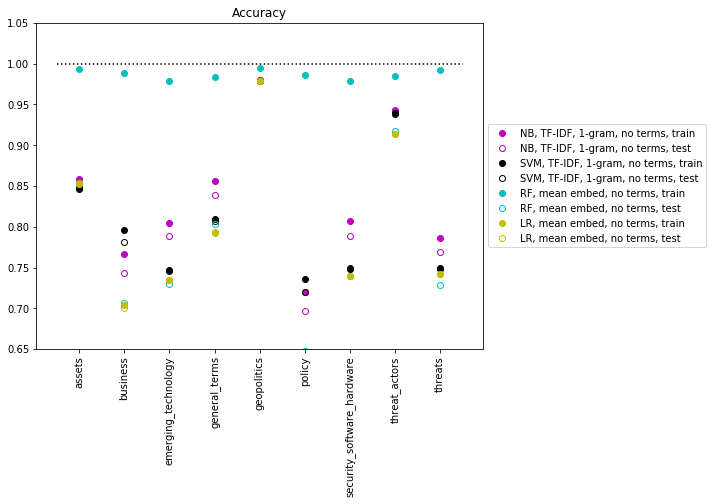

In [139]:
acc_train_nb_tv1_removed = [performance_nb_tv1_removed[x]["acc_train"] if performance_nb_tv1_removed[x] else 0 for x in categories]
acc_test_nb_tv1_removed = [performance_nb_tv1_removed[x]["acc_test"] if performance_nb_tv1_removed[x] else 0 for x in categories]
acc_train_svm_tv1_removed = [performance_svm_tv1_removed[x]["acc_train"] if performance_svm_tv1_removed[x] else 0 for x in categories]
acc_test_svm_tv1_removed = [performance_svm_tv1_removed[x]["acc_test"] if performance_svm_tv1_removed[x] else 0 for x in categories]
acc_train_rf_meanembed_removed = [performance_rf_meanembed_removed[x]["acc_train"] if performance_rf_meanembed_removed[x] else 0 for x in categories]
acc_test_rf_meanembed_removed = [performance_rf_meanembed_removed[x]["acc_test"] if performance_rf_meanembed_removed[x] else 0 for x in categories]
acc_train_lr_meanembed_removed = [performance_lr_meanembed_removed[x]["acc_train"] if performance_lr_meanembed_removed[x] else 0 for x in categories]
acc_test_lr_meanembed_removed = [performance_lr_meanembed_removed[x]["acc_test"] if performance_lr_meanembed_removed[x] else 0 for x in categories]

plt.figure(figsize=(8,6))
plt.plot(categories, acc_train_nb_tv1_removed, "mo", fillstyle="full", label="NB, TF-IDF, 1-gram, no terms, train")
plt.plot(categories, acc_test_nb_tv1_removed, "mo", fillstyle="none", label="NB, TF-IDF, 1-gram, no terms, test")
plt.plot(categories, acc_train_svm_tv1_removed, "ko", fillstyle="full", label="SVM, TF-IDF, 1-gram, no terms, train")
plt.plot(categories, acc_test_svm_tv1_removed, "ko", fillstyle="none", label="SVM, TF-IDF, 1-gram, no terms, test")
plt.plot(categories, acc_train_rf_meanembed_removed, "co", fillstyle="full", label="RF, mean embed, no terms, train")
plt.plot(categories, acc_test_rf_meanembed_removed, "co", fillstyle="none", label="RF, mean embed, no terms, test")
plt.plot(categories, acc_train_lr_meanembed_removed, "yo", fillstyle="full", label="LR, mean embed, no terms, train")
plt.plot(categories, acc_test_lr_meanembed_removed, "yo", fillstyle="none", label="LR, mean embed, no terms, test")
plt.xticks(rotation='vertical')
plt.ylim([0.65, 1.05])
plt.plot([-.5, len(categories)-.5], [1, 1], 'k:')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Accuracy");

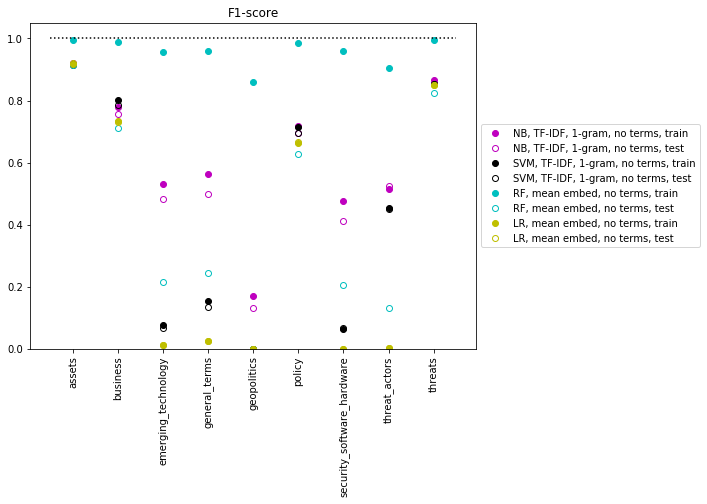

In [140]:
f1_train_nb_tv1_removed = [performance_nb_tv1_removed[x]["f1_train"] if performance_nb_tv1_removed[x] else 0 for x in categories]
f1_test_nb_tv1_removed = [performance_nb_tv1_removed[x]["f1_test"] if performance_nb_tv1_removed[x] else 0 for x in categories]
f1_train_svm_tv1_removed = [performance_svm_tv1_removed[x]["f1_train"] if performance_svm_tv1_removed[x] else 0 for x in categories]
f1_test_svm_tv1_removed = [performance_svm_tv1_removed[x]["f1_test"] if performance_svm_tv1_removed[x] else 0 for x in categories]
f1_train_rf_meanembed_removed = [performance_rf_meanembed_removed[x]["f1_train"] if performance_rf_meanembed_removed[x] else 0 for x in categories]
f1_test_rf_meanembed_removed = [performance_rf_meanembed_removed[x]["f1_test"] if performance_rf_meanembed_removed[x] else 0 for x in categories]
f1_train_lr_meanembed_removed = [performance_lr_meanembed_removed[x]["f1_train"] if performance_lr_meanembed_removed[x] else 0 for x in categories]
f1_test_lr_meanembed_removed = [performance_lr_meanembed_removed[x]["f1_test"] if performance_lr_meanembed_removed[x] else 0 for x in categories]

plt.figure(figsize=(8,6))
plt.plot(categories, f1_train_nb_tv1_removed, "mo", fillstyle="full", label="NB, TF-IDF, 1-gram, no terms, train")
plt.plot(categories, f1_test_nb_tv1_removed, "mo", fillstyle="none", label="NB, TF-IDF, 1-gram, no terms, test")
plt.plot(categories, f1_train_svm_tv1_removed, "ko", fillstyle="full", label="SVM, TF-IDF, 1-gram, no terms, train")
plt.plot(categories, f1_test_svm_tv1_removed, "ko", fillstyle="none", label="SVM, TF-IDF, 1-gram, no terms, test")
plt.plot(categories, f1_train_rf_meanembed_removed, "co", fillstyle="full", label="RF, mean embed, no terms, train")
plt.plot(categories, f1_test_rf_meanembed_removed, "co", fillstyle="none", label="RF, mean embed, no terms, test")
plt.plot(categories, f1_train_lr_meanembed_removed, "yo", fillstyle="full", label="LR, mean embed, no terms, train")
plt.plot(categories, f1_test_lr_meanembed_removed, "yo", fillstyle="none", label="LR, mean embed, no terms, test")
plt.xticks(rotation='vertical')
plt.ylim([0., 1.05])
plt.plot([-.5, len(categories)-.5], [1, 1], 'k:')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("F1-score");